### Classification of Plant species from the Smithsonian collection. 🍀
For classification we are using [Leafsnap](http://leafsnap.com/dataset/) dataset, which consists of images of leaves taken from two different sources.
1. 23147 Lab images, consisting of high-quality images taken of pressed leaves, from the Smithsonian collection. These images appear in controlled backlit and front-lit versions, with several samples per species.
2. 7719 Field images, consisting of "typical" images taken by mobile devices (iPhones mostly) in outdoor environments. These images contain varying amounts of blur, noise, illumination patterns, shadows, etc.

No of Plant Species classified in this work : 

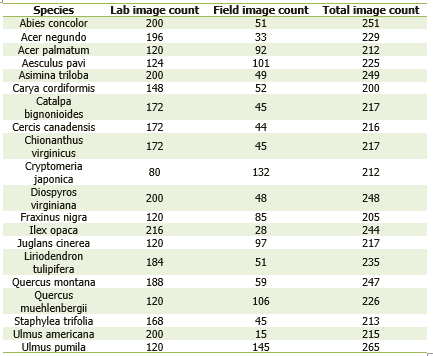

## Method
The idea is to use a pre-tained mode, in this case VGG16 model, which consists of several convolutional layers, followed by some fully-connected / dense layers and then a softmax output layer for the classification.

Features are extracted from the convolutionl layers and these layers are combined with dense layers which helps in the final classification. So also add dropout layer to avoid overfitting.

Here, we use two techniques:
1. Pre-trained Model : For predicting the class of some images from Leafsnap dataset.
2. Fine-Tuning : We optimize both the weights of the new classification layers we have added, as well as some or ll the layers from the VGG16 model.

# Steps: 
1.   Import Libraries
2.   Import from Keras API
3.   Developed using Python 3.7.13 and Tensorflow version 2.8.2
4.   Helper Functions from [Hvass-Labs](https://www.hvass-labs.org/)
5.   Pre-trained Model - VGG16
6.   Transfer Learning
7.   Fine-Tuning



In [ ]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import numpy as np
import os

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop

In [ ]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [ ]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [ ]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    print("Confusion matrix:")
    
    # Print the confusion matrix as text.
    print(cm)
    
    # Print the class-names for easy reference.
    for i, class_name in enumerate(class_names):
        print("({0}) {1}".format(i, class_name))
 
def plot_classification_report(cls_pred):
   cr = classification_report(y_true=cls_test, y_pred=cls_pred, class_names=class_names)
   print('classification report:')

   print(cr)




In [ ]:
def plot_example_errors(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Boolean array whether the predicted class is incorrect.
    incorrect = (cls_pred != cls_test)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [ ]:
def example_errors():
    # The Keras data-generator for the test-set must be reset
    # before processing. This is because the generator will loop
    # infinitely and keep an internal index into the dataset.
    # So it might start in the middle of the test-set if we do
    # not reset it first. This makes it impossible to match the
    # predicted classes with the input images.
    # If we reset the generator, then it always starts at the
    # beginning so we know exactly which input-images were used.
    generator_test.reset()
    
    # Predict the classes for all images in the test-set.
    y_pred = new_model.predict(generator_test, steps=steps_test)

    # Convert the predicted classes from arrays to integers.
    cls_pred = np.argmax(y_pred,axis=1)

    # Plot examples of mis-classified images.
    plot_example_errors(cls_pred)
    
    # Print the confusion matrix.
    print_confusion_matrix(cls_pred)

In [ ]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [ ]:
def plot_training_history(history):
    # Get the classification accuracy and loss-value
    # for the training-set.
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    # Get it for the validation-set (we only use the test-set).
    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    # Plot the accuracy and loss-values for the training-set.
    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(loss, 'o', color='b', label='Training Loss')
    
    # Plot it for the test-set.
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.plot(val_loss, 'o', color='r', label='Test Loss')

    # Plot title and legend.
    plt.title('Training and Test Accuracy')
    plt.legend()

    # Ensure the plot shows correctly.
    plt.show()

In [ ]:
train_dir = '/content/drive/MyDrive/Colab Notebooks/leafsnap/leafsnap/dataset/train'
test_dir = '/content/drive/MyDrive/Colab Notebooks/leafsnap/leafsnap/dataset/val'

In [ ]:
model = VGG16(include_top=True, weights='imagenet')

553476096/553467096 [==============================] - 2s 0us/step


In [ ]:
input_shape = model.layers[0].output_shape[0][1:3]
input_shape

(224, 224)

In [ ]:
datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=180,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=[0.9, 1.5],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

In [ ]:
datagen_test = ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 16

In [ ]:
if True:
    save_to_dir = None
else:
    save_to_dir= '/content/drive/MyDrive/Colab Notebooks/leafsnap_dataset_20class_200counts/augmented images/'

In [ ]:
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True,
                                                    save_to_dir=save_to_dir)

Found 2571 images belonging to 20 classes.


In [ ]:
generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)

Found 649 images belonging to 20 classes.


In [ ]:
steps_test = generator_test.n / batch_size
steps_test

40.5625

In [ ]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

In [ ]:
cls_train = generator_train.classes
cls_test = generator_test.classes

In [ ]:
class_names = list(generator_train.class_indices.keys())
class_names

['abies_concolor',
 'acer_negundo',
 'acer_palmatum',
 'aesculus_pavi',
 'asimina_triloba',
 'carya_cordiformis',
 'catalpa_bignonioides',
 'cercis_canadensis',
 'chionanthus_virginicus',
 'cryptomeria_japonica',
 'diospyros_virginiana',
 'fraxinus_nigra',
 'ilex_opaca',
 'juglans_cinerea',
 'liriodendron_tulipifera',
 'quercus_montana',
 'quercus_muehlenbergii',
 'staphylea_trifolia',
 'ulmus_americana',
 'ulmus_pumila']

In [ ]:
num_classes = generator_train.num_classes
num_classes

20

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
class_weight = compute_class_weight(class_weight='balanced',
                                    classes=np.unique(cls_train),
                                    y=cls_train)

In [ ]:
class_weight

array([0.8034375 , 0.82403846, 1.3390625 , 1.29848485, 0.8034375 ,
       1.08940678, 0.93832117, 0.93832117, 0.93832117, 2.00859375,
       0.8034375 , 1.3390625 , 0.74738372, 1.3390625 , 0.8744898 ,
       0.857     , 1.3390625 , 0.95932836, 0.8034375 , 1.3390625 ])

In [ ]:
def predict(image_path):
    # Load and resize the image using PIL.
    img = PIL.Image.open(image_path)
    img_resized = img.resize(input_shape, PIL.Image.LANCZOS)

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the PIL image to a numpy-array with the proper shape.
    img_array = np.expand_dims(np.array(img_resized), axis=0)

    # Use the VGG16 model to make a prediction.
    # This outputs an array with 1000 numbers corresponding to
    # the classes of the ImageNet-dataset.
    pred = model.predict(img_array)
    
    # Decode the output of the VGG16 model.
    pred_decoded = decode_predictions(pred)[0]

    # Print the predictions.
    for code, name, score in pred_decoded:
        print("{0:>6.2%} : {1}".format(score, name))

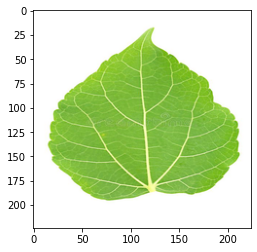

49152/35363 [=========================================] - 0s 0us/step
98.28% : head_cabbage
 0.79% : cauliflower
 0.36% : fig
 0.12% : lemon
 0.08% : cucumber


In [ ]:
predict(image_path='/content/drive/MyDrive/Colab Notebooks/leafsnap/leafsnap/dataset/back-side-mulberry.jpg')

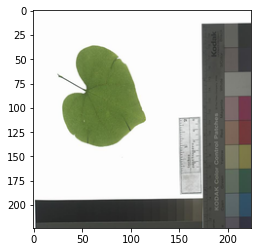

50.40% : envelope
11.65% : web_site
 2.62% : Band_Aid
 2.53% : desktop_computer
 2.04% : desk


In [ ]:
predict(image_path=image_paths_train[1000])
                                  

In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
transfer_layer = model.get_layer('block5_pool')

In [ ]:
transfer_layer.output

<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [ ]:
conv_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [ ]:
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add the final layer for the actual classification.
new_model.add(Dense(num_classes, activation='softmax'))

In [ ]:
optimizer = Adam(lr=1e-5)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
loss = 'categorical_crossentropy'

In [ ]:
metrics = ['categorical_accuracy']

In [ ]:
def print_layer_trainable():
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable()

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool


In [ ]:
conv_model.trainable = False

In [ ]:
for layer in conv_model.layers:
    layer.trainable = False

In [ ]:
print_layer_trainable()

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool


In [ ]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:
batch_size = 16

In [ ]:
epochs = 100
steps_per_epoch = 2571/batch_size

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=epochs,
                        steps_per_epoch=steps_per_epoch,
                        #class_weight=class_weight,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/100
160/160 [==============================] - 1252s 8s/step - loss: 2.8599 - categorical_accuracy: 0.1478 - val_loss: 2.1663 - val_categorical_accuracy: 0.5300
Epoch 2/100
160/160 [==============================] - 61s 379ms/step - loss: 2.1323 - categorical_accuracy: 0.3928 - val_loss: 1.6059 - val_categorical_accuracy: 0.6487
Epoch 3/100
160/160 [==============================] - 60s 374ms/step - loss: 1.6943 - categorical_accuracy: 0.5298 - val_loss: 1.2390 - val_categorical_accuracy: 0.7149
Epoch 4/100
160/160 [==============================] - 60s 370ms/step - loss: 1.4239 - categorical_accuracy: 0.6021 - val_loss: 1.0140 - val_categorical_accuracy: 0.7781
Epoch 5/100
160/160 [==============================] - 62s 383ms/step - loss: 1.2092 - categorical_accuracy: 0.6624 - val_loss: 0.8813 - val_categorical_accuracy: 0.7874
Epoch 6/100
160/160 [==============================] - 61s 378ms/step - loss: 1.0864 - categorical_accuracy: 0.7009 - val_loss: 0.7637 - val_categorica

In [ ]:
from tensorflow.keras.models import load_model
new_model.save('leafsnap_model_vgg16.h5')

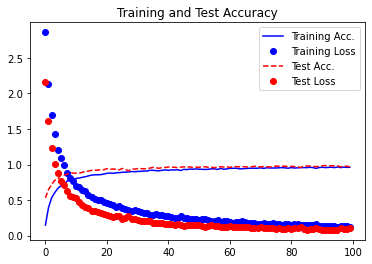

In [ ]:
plot_training_history(history)

In [ ]:
result = new_model.evaluate(generator_test, steps=steps_test)

40/40 [==============================] - 6s 156ms/step - loss: 0.1037 - categorical_accuracy: 0.9676


In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

Test-set classification accuracy: 96.76%


In [ ]:
from tensorflow.keras.models import load_model
new_model=load_model('/content/drive/MyDrive/Colab Notebooks/leafsnap/leafsnap_model_vgg16.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  


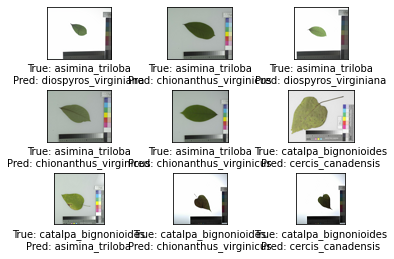

Confusion matrix:
[[40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 24  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 35  0  0  0  3  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0 30  2  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 35  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0 32  0  2  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  1  0 38  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 44  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 24  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 37  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0

In [ ]:
example_errors()

### **Fine Tuning**

In [ ]:
new_model.trainable = True

In [ ]:
for layer in new_model.layers:
    # Boolean whether this layer is trainable.
    trainable = ('block5' in layer.name or 'block4' in layer.name)
    
    # Set the layer's bool.
    layer.trainable = trainable

In [ ]:
def print_layer_trainable():
    for layer in new_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [ ]:
print_layer_trainable()

False:	model
False:	flatten
False:	dense
False:	dropout
False:	dense_1


In [ ]:
optimizer_fine = Adam(lr=1e-7)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
new_model.compile(optimizer=optimizer_fine, loss=loss, metrics=metrics)

In [ ]:
history = new_model.fit(x=generator_train,
                        epochs=20,
                        steps_per_epoch=steps_per_epoch,
                        # class_weight=class_weight,
                        validation_data=generator_test,
                        validation_steps=steps_test)

Epoch 1/20
160/160 [==============================] - 1092s 7s/step - loss: 0.1397 - categorical_accuracy: 0.9549 - val_loss: 0.1037 - val_categorical_accuracy: 0.9676
Epoch 2/20
160/160 [==============================] - 58s 361ms/step - loss: 0.1243 - categorical_accuracy: 0.9584 - val_loss: 0.1037 - val_categorical_accuracy: 0.9676
Epoch 3/20
160/160 [==============================] - 57s 354ms/step - loss: 0.1287 - categorical_accuracy: 0.9599 - val_loss: 0.1037 - val_categorical_accuracy: 0.9676
Epoch 4/20
160/160 [==============================] - 57s 354ms/step - loss: 0.1249 - categorical_accuracy: 0.9623 - val_loss: 0.1037 - val_categorical_accuracy: 0.9676
Epoch 5/20
160/160 [==============================] - 57s 356ms/step - loss: 0.1338 - categorical_accuracy: 0.9584 - val_loss: 0.1037 - val_categorical_accuracy: 0.9676
Epoch 6/20
160/160 [==============================] - 59s 369ms/step - loss: 0.1348 - categorical_accuracy: 0.9580 - val_loss: 0.1037 - val_categorical_accu

In [ ]:
plot_training_history(history)

In [ ]:
result = new_model.evaluate(generator_test, steps=steps_test)

In [ ]:
print("Test-set classification accuracy: {0:.2%}".format(result[1]))

In [ ]:
example_errors()

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/leafsnap

/content/drive/MyDrive/Colab Notebooks/leafsnap


In [ ]:
!pip freeze >requirements.txt

In [ ]:
!pip install pipreqs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pipreqs --force

INFO: Successfully saved requirements file in /content/drive/MyDrive/Colab Notebooks/leafsnap/requirements.txt


In [ ]:
!pip list

In [ ]:
!pip freeze -l > requirements.txt 